C:\Users\Aniruddha\anaconda3\lib\site-packages\pyarrow\pandas_compat.py:951: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  index = pd.Index(index, name=index_names[0])
C:\Users\Aniruddha\AppData\Local\Temp\ipykernel_3552\2796143548.py:162: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return s.pct_change(lag) * 100.0


Using master: data\processed\master_panel.csv


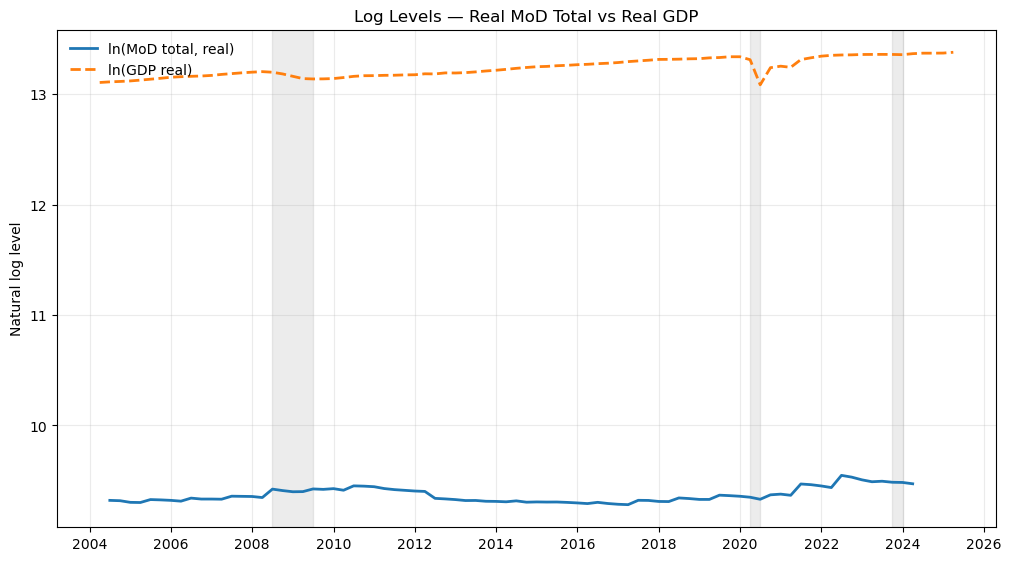

C:\Users\Aniruddha\AppData\Local\Temp\ipykernel_3552\2796143548.py:162: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return s.pct_change(lag) * 100.0


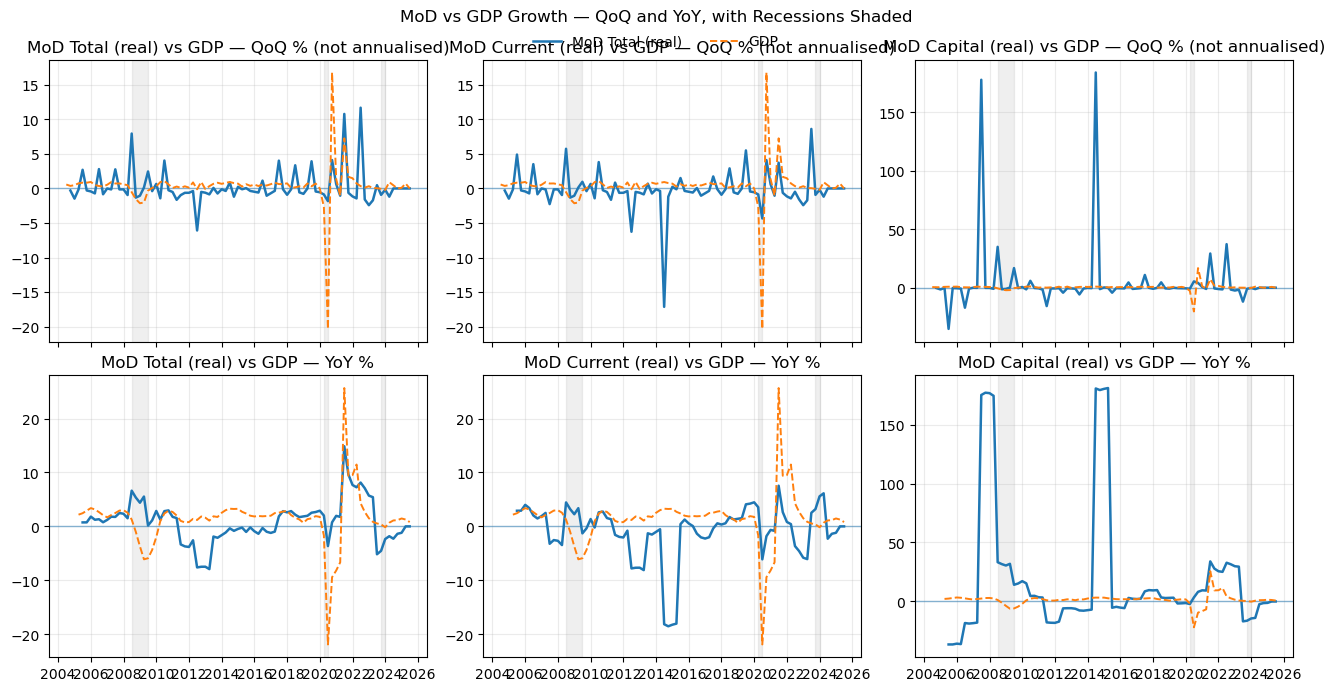

Saved:
 - figures\phaseB_log_levels_mod_vs_gdp.png
 - figures\phaseB_growth_small_multiples.png


In [1]:
# Level plots (logs) & growth plots with recession shading
# -------------------------------------------------------
from __future__ import annotations
import warnings, glob, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ----------------------- Config -----------------------
SEARCH_PATTERNS = [
    "data/processed/master_panel_*.csv",
    "data/processed/master_panel.csv",
    "/mnt/data/master_panel_*.csv",
    "/mnt/data/master_panel.csv",
    # Parquet (future-proof)
    "data/processed/master_panel_*.parquet",
    "data/processed/master_panel.parquet",
    "/mnt/data/master_panel_*.parquet",
    "/mnt/data/master_panel.parquet",
]
FIG_DIR = Path("figures")
FIG_DPI = 160
START_Q = "2004Q1"   # set to None to keep full span
END_Q   = None       # e.g., "2024Q4"
# ------------------------------------------------------

# ------- Synonym groups so we can handle varied master naming -------
GDP_REAL_SYNS   = ["gdp_real_mn","gdp_real_abmi","gdp_real","real_gdp_abmi","rgdp_abmi","rgdp"]
GDP_NOM_SYNS    = ["gdp_nom_mn","gdp_nominal_mn","gdp_nominal","ybha_nominal","ybha_mn"]
DEFLATOR_SYNS   = ["gdp_deflator_index","gdp_deflator_ybgb","ybgb_index","deflator_index"]
MOD_TOT_NOM     = ["total","mod_total_nom","mod_total_nominal","mod_total_nom_mn","mod_total_gbp"]
MOD_CUR_NOM     = ["current","mod_cur_nom","mod_current_nom","mod_current_nominal","mod_current_nom_mn"]
MOD_CAP_NOM     = ["capital","mod_cap_nom","mod_capital_nom","mod_capital_nominal","mod_cap_nom_mn"]
ESCOE_SYNS      = ["escoe_recession","escoe_rec","escoe_recession_flag"]
# -------------------------------------------------------------------

def _read_any(p: Path) -> pd.DataFrame:
    suff = p.suffix.lower()
    if suff == ".csv":
        return pd.read_csv(p)
    if suff in {".parquet",".pq"}:
        return pd.read_parquet(p)
    raise ValueError(f"Unsupported file type: {suff}")

def _list_master_candidates(patterns: list[str]) -> list[Path]:
    hits: list[Path] = []
    for pat in patterns:
        hits.extend([Path(x) for x in glob.glob(pat)])
    return [p for p in hits if p.is_file()]

def _has_measures(df: pd.DataFrame, measures: list[str]) -> int:
    """Return count of how many target measures exist in df (long or wide)."""
    if {"measure","period","value"}.issubset(df.columns):
        avail = set(df["measure"].astype(str).unique())
    else:
        avail = set(map(str, df.columns))
    return sum(m in avail for m in measures)

def _find_best_master(patterns: list[str]) -> Path:
    cands = _list_master_candidates(patterns)
    if not cands:
        raise FileNotFoundError("No master panel found in expected locations.")
    # Prefer the newest file with the highest presence of anchor measures
    anchor = GDP_REAL_SYNS + DEFLATOR_SYNS + MOD_TOT_NOM
    best, best_score, best_mtime = None, -1, -1
    for p in cands:
        try:
            df = _read_any(p)
            score = _has_measures(df, anchor)
            mtime = p.stat().st_mtime
            if score > best_score or (score == best_score and mtime > best_mtime):
                best, best_score, best_mtime = p, score, mtime
        except Exception:
            continue
    if best is None:
        # Fallback: pick newest
        best = max(cands, key=lambda x: x.stat().st_mtime)
    print(f"Using master: {best}")
    return best

# ---------- Quarter parsing (robust) ----------
_Q_PATTERNS = [
    re.compile(r"^\s*(\d{4})\s*[-_/]?\s*[Qq]\s*([1-4])\s*$"),   # 2004Q1 or 2004-Q1
    re.compile(r"^\s*[Qq]\s*([1-4])\s*[-_/]?\s*(\d{4})\s*$"),   # Q1 2004
]

def _normalize_quarter_strings(vals) -> pd.Series:
    s = pd.Series(vals).astype("string").str.strip()

    def _norm_one(x: str | None) -> str | None:
        if x is None or x == "" or x.lower() == "nan":
            return None
        for pat in _Q_PATTERNS:
            m = pat.match(x)
            if m:
                if pat is _Q_PATTERNS[0]:
                    y, q = m.group(1), m.group(2)
                else:
                    q, y = m.group(1), m.group(2)
                return f"{y}Q{q}"
        if re.match(r"^\d{4}Q[1-4]$", x):
            return x
        dt = pd.to_datetime(x, errors="coerce", dayfirst=False)
        if pd.isna(dt): return None
        per = pd.Period(dt, freq="Q")
        return f"{per.year}Q{per.quarter}"

    return s.map(_norm_one)

def _quarter_end_index_from_column(df: pd.DataFrame, col: str) -> pd.DatetimeIndex:
    norm = _normalize_quarter_strings(df[col])
    good = ~norm.isna()
    if not good.any():
        raise ValueError(f"Could not parse any quarter values from column '{col}'.")
    per = pd.PeriodIndex(norm[good].tolist(), freq="Q")
    return per.to_timestamp(how="end")

def _ensure_quarter_end_index(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # Preferred: explicit quarter_end
    for c in ["quarter_end","Quarter_end","quarterEnd","QuarterEnd"]:
        if c in out.columns:
            dt = pd.to_datetime(out[c], errors="coerce")
            out = out.loc[~dt.isna()].drop(columns=[c])
            out.index = dt[~dt.isna()].to_period("Q").to_timestamp(how="end")
            return out.sort_index()
    # Next: period/quarter as strings
    for c in ["period","quarter","Quarter","date","Date"]:
        if c in out.columns:
            idx = _quarter_end_index_from_column(out, c)
            out = out.loc[~_normalize_quarter_strings(out[c]).isna()].drop(columns=[c])
            out.index = idx
            return out.sort_index()
    # Already indexed?
    if isinstance(out.index, pd.PeriodIndex):
        return out.sort_index().to_timestamp(how="end")
    if isinstance(out.index, pd.DatetimeIndex):
        out.index = out.index.to_period("Q").to_timestamp(how="end")
        return out.sort_index()
    raise ValueError("Could not locate a usable quarter column/index.")

# ---------- Long → Wide pivot if needed ----------
def _to_wide(df: pd.DataFrame) -> pd.DataFrame:
    if {"measure","period","value"}.issubset(df.columns):
        wide = df.pivot(index="period", columns="measure", values="value")
        wide.columns = [str(c) for c in wide.columns]
        wide = wide.reset_index()
    else:
        wide = df.copy()
    return _ensure_quarter_end_index(wide)

# ---------- Helpers ----------
def _pick(df: pd.DataFrame, candidates: list[str]) -> str | None:
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _growth_pct(s: pd.Series, lag: int) -> pd.Series:
    return s.pct_change(lag) * 100.0

def _compute_technical_recession_flags(rgdp: pd.Series) -> pd.Series:
    qoq = _growth_pct(rgdp, 1)
    neg = qoq < 0
    blocks = (neg != neg.shift()).cumsum()
    runlen = blocks.groupby(blocks).transform("size")
    return (neg & (runlen >= 2)).rename("rec_tech")

def _recession_spans(flag: pd.Series | None) -> list[tuple[pd.Timestamp, pd.Timestamp]]:
    if flag is None:
        return []
    s = flag.copy().fillna(False).astype(bool)
    s.index = pd.to_datetime(s.index)
    starts = s & ~s.shift(1, fill_value=False)
    ends   = s & ~s.shift(-1, fill_value=False)
    return [(pd.Timestamp(st), pd.Timestamp(en) + pd.offsets.Day(1))
            for st, en in zip(starts.index[starts], ends.index[ends])]

def main():
    FIG_DIR.mkdir(parents=True, exist_ok=True)

    src = _find_best_master(SEARCH_PATTERNS)
    raw = _read_any(src)
    df  = _to_wide(raw)
    # Optional window
    if START_Q or END_Q:
        per = df.index.to_period("Q")
        mask = pd.Series(True, index=df.index)
        if START_Q: mask &= per >= pd.Period(START_Q, freq="Q")
        if END_Q:   mask &= per <= pd.Period(END_Q,   freq="Q")
        df = df.loc[mask]

    # -------- Locate / build GDP real --------
    gdp_real = _pick(df, GDP_REAL_SYNS)
    if gdp_real is None:
        gdp_nom  = _pick(df, GDP_NOM_SYNS)
        deflator = _pick(df, DEFLATOR_SYNS)
        if gdp_nom and deflator:
            denom = (df[deflator] / 100.0).replace({0: np.nan})
            df["gdp_real_mn_autogen"] = df[gdp_nom] / denom
            gdp_real = "gdp_real_mn_autogen"
        else:
            raise KeyError(f"Could not find/construct GDP real. "
                           f"Looked for real {GDP_REAL_SYNS} or nominal {GDP_NOM_SYNS} + deflator {DEFLATOR_SYNS}.")

    # -------- Locate / build MoD real (total/current/capital) --------
    deflator = _pick(df, DEFLATOR_SYNS)
    if deflator is None:
        raise KeyError(f"Missing GDP deflator in master. Tried: {DEFLATOR_SYNS}")
    denom = (df[deflator] / 100.0).replace({0: np.nan})

    tot_nom = _pick(df, MOD_TOT_NOM)
    if tot_nom is None:
        raise KeyError(f"Missing MoD nominal TOTAL in master. Tried: {MOD_TOT_NOM}")
    df["mod_total_real"] = df[tot_nom] / denom

    cur_nom = _pick(df, MOD_CUR_NOM)
    cap_nom = _pick(df, MOD_CAP_NOM)
    if cur_nom is not None:
        df["mod_cur_real"] = df[cur_nom] / denom
    if cap_nom is not None:
        df["mod_cap_real"] = df[cap_nom] / denom

    # -------- Recession shading --------
    escoe = _pick(df, ESCOE_SYNS)
    rec_series = df[escoe].astype(int).astype(bool) if escoe else _compute_technical_recession_flags(df[gdp_real])
    spans = _recession_spans(rec_series)

    # ----------------- Figure 1: Log levels -----------------
    ln_mod = np.log(df["mod_total_real"].where(df["mod_total_real"] > 0))
    ln_gdp = np.log(df[gdp_real].where(df[gdp_real] > 0))

    fig1, ax1 = plt.subplots(figsize=(10, 5.5), constrained_layout=True)
    ax1.plot(ln_mod.index, ln_mod, label="ln(MoD total, real)", linewidth=2)
    ax1.plot(ln_gdp.index, ln_gdp, label="ln(GDP real)", linewidth=2, linestyle="--")
    for st, en in spans:
        ax1.axvspan(st, en, color="grey", alpha=0.15)

    ax1.set_title("Log Levels — Real MoD Total vs Real GDP")
    ax1.set_ylabel("Natural log level")
    ax1.set_xlabel("")
    ax1.legend(loc="upper left", frameon=False)
    ax1.grid(True, alpha=0.25)
    ax1.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    out1 = FIG_DIR / "phaseB_log_levels_mod_vs_gdp.png"
    fig1.savefig(out1, dpi=FIG_DPI)
    plt.show()

    # ----------------- Figure 2: QoQ & YoY small multiples -----------------
    panels = [
        ("mod_total_real", "MoD Total (real)"),
        ("mod_cur_real",   "MoD Current (real)"),
        ("mod_cap_real",   "MoD Capital (real)"),
    ]
    gdp_qoq = _growth_pct(df[gdp_real], 1).rename("GDP QoQ %")
    gdp_yoy = _growth_pct(df[gdp_real], 4).rename("GDP YoY %")

    ncols, nrows = len(panels), 2
    fig2, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13, 6.5), sharex=True, constrained_layout=True)

    legend_handles, legend_labels = None, None
    for j, (col, nicename) in enumerate(panels):
        if col not in df.columns:
            for i in range(nrows):
                axes[i, j].text(0.5, 0.5, f"{nicename}\n(missing)", ha="center", va="center")
                axes[i, j].axis("off")
            continue

        s_qoq = _growth_pct(df[col], 1).rename(f"{nicename} QoQ %")
        s_yoy = _growth_pct(df[col], 4).rename(f"{nicename} YoY %")

        # Row 0: QoQ
        ax = axes[0, j]
        ax.axhline(0, linewidth=1, alpha=0.5)
        l1, = ax.plot(s_qoq.index, s_qoq, label=f"{nicename}", linewidth=1.8)
        l2, = ax.plot(gdp_qoq.index, gdp_qoq, label="GDP", linewidth=1.4, linestyle="--")
        for st, en in spans:
            ax.axvspan(st, en, color="grey", alpha=0.12)
        ax.set_title(f"{nicename} vs GDP — QoQ % (not annualised)")
        ax.grid(True, alpha=0.25)
        if legend_handles is None:
            legend_handles, legend_labels = [l1, l2], [l1.get_label(), l2.get_label()]

        # Row 1: YoY
        ax = axes[1, j]
        ax.axhline(0, linewidth=1, alpha=0.5)
        ax.plot(s_yoy.index, s_yoy, label=f"{nicename}", linewidth=1.8)
        ax.plot(gdp_yoy.index, gdp_yoy, label="GDP", linewidth=1.4, linestyle="--")
        for st, en in spans:
            ax.axvspan(st, en, color="grey", alpha=0.12)
        ax.set_title(f"{nicename} vs GDP — YoY %")
        ax.grid(True, alpha=0.25)

    for i in range(nrows):
        for j in range(ncols):
            ax = axes[i, j]
            if hasattr(ax, "xaxis"):
                ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
                ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    if legend_handles:
        fig2.legend(legend_handles, legend_labels, ncol=4, loc="upper center", frameon=False, bbox_to_anchor=(0.5, 1.02))

    fig2.suptitle("MoD vs GDP Growth — QoQ and YoY, with Recessions Shaded", y=1.04)
    out2 = FIG_DIR / "phaseB_growth_small_multiples.png"
    fig2.savefig(out2, dpi=FIG_DPI)
    plt.show()

    print("Saved:")
    print(f" - {out1}")
    print(f" - {out2}")

# Run
main()

C:\Users\Aniruddha\anaconda3\lib\site-packages\pyarrow\pandas_compat.py:951: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  index = pd.Index(index, name=index_names[0])


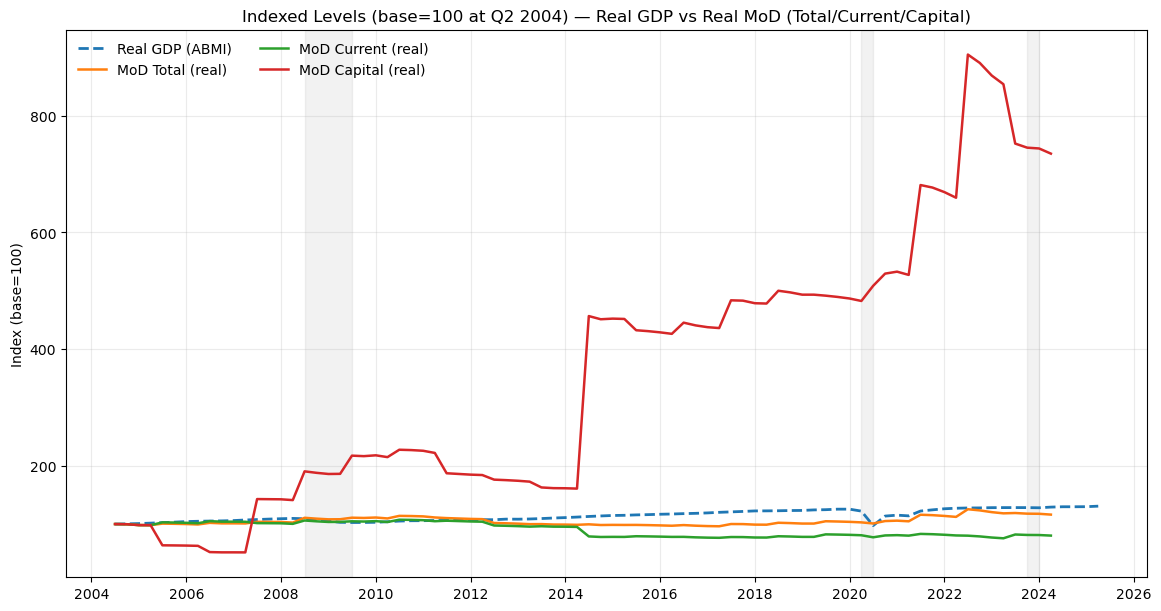

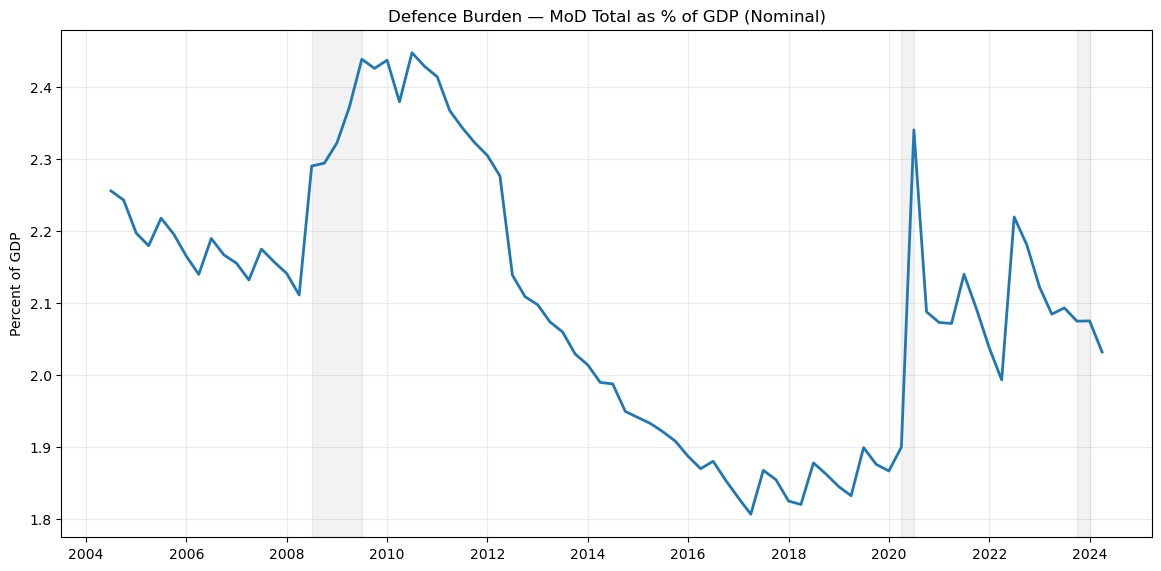

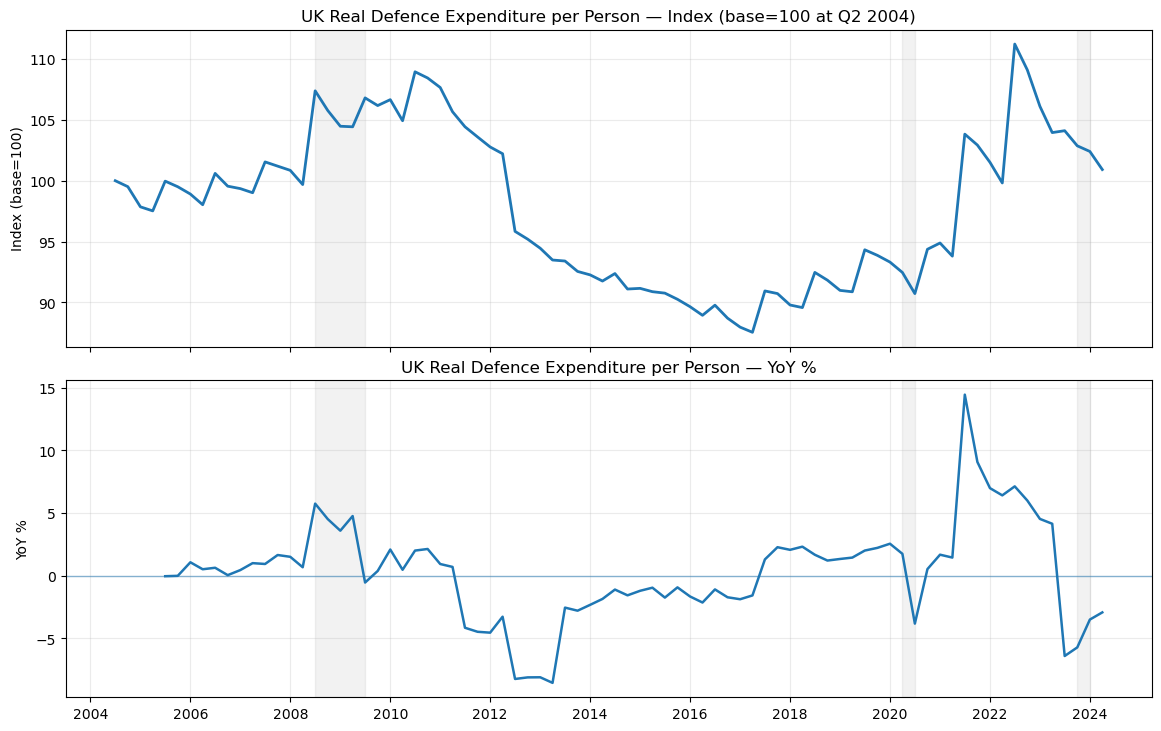

Saved charts:
 - figures\phaseB_indexed_levels_real_gdp_vs_mod.png
 - figures\phaseB_defence_burden_percent_of_gdp.png
 - figures\phaseB_real_defence_per_capita_index_and_yoy.png


In [2]:
# Phase B — Extra EDA Charts
# -------------------------------------------------------
from __future__ import annotations
import warnings, glob, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ----------------------- Config -----------------------
SEARCH_PATTERNS = [
    "data/processed/master_panel_*.csv",
    "data/processed/master_panel.csv",
    "/mnt/data/master_panel_*.csv",
    "/mnt/data/master_panel.csv",
    # Parquet (if you saved one)
    "data/processed/master_panel_*.parquet",
    "data/processed/master_panel.parquet",
    "/mnt/data/master_panel_*.parquet",
    "/mnt/data/master_panel.parquet",
]
FIG_DIR = Path("figures")
FIG_DPI = 160
START_Q = "2004Q2"   # use your overlap start; set None for full span
END_Q   = None       # e.g., "2024Q1"
# ------------------------------------------------------

# ------- Synonym groups (aligns to your A02 master) -------
GDP_REAL_SYNS   = ["gdp_real_mn","gdp_real_abmi","gdp_real","real_gdp_abmi","rgdp_abmi","rgdp"]
GDP_NOM_SYNS    = ["gdp_nom_mn","gdp_nominal_mn","gdp_nominal","ybha_nominal","ybha_mn"]
DEFLATOR_SYNS   = ["gdp_deflator_index","gdp_deflator_ybgb","ybgb_index","deflator_index"]
MOD_TOT_NOM     = ["total","mod_total_nom","mod_total_nominal","mod_total_nom_mn","mod_total_gbp"]
MOD_CUR_NOM     = ["current","mod_cur_nom","mod_current_nom","mod_current_nominal","mod_current_nom_mn"]
MOD_CAP_NOM     = ["capital","mod_cap_nom","mod_capital_nom","mod_capital_nominal","mod_cap_nom_mn"]
POP_PERSONS     = ["population_persons","pop_persons","population"]
POP_THOUS       = ["population_thousands","pop_thousands","pop_thous","population_thous"]
ESCOE_SYNS      = ["escoe_recession","escoe_rec","escoe_recession_flag"]
# ----------------------------------------------------------

def _read_any(p: Path) -> pd.DataFrame:
    suff = p.suffix.lower()
    if suff == ".csv":
        return pd.read_csv(p)
    if suff in {".parquet",".pq"}:
        return pd.read_parquet(p)
    raise ValueError(f"Unsupported file type: {suff}")

def _list_master_candidates(patterns: list[str]) -> list[Path]:
    return [Path(x) for x in sum((glob.glob(pat) for pat in patterns), []) if Path(x).is_file()]

def _find_best_master(patterns: list[str]) -> Path:
    cands = _list_master_candidates(patterns)
    if not cands:
        raise FileNotFoundError("No master panel found in expected locations.")
    # Prefer newest with most anchor measures present
    anchor = GDP_REAL_SYNS + GDP_NOM_SYNS + DEFLATOR_SYNS + MOD_TOT_NOM
    best, best_score, best_mtime = None, -1, -1
    for p in cands:
        try:
            df = _read_any(p)
            if {"measure","period","value"}.issubset(df.columns):
                avail = set(df["measure"].astype(str).unique())
            else:
                avail = set(map(str, df.columns))
            score = sum(m in avail for m in anchor)
            mtime = p.stat().st_mtime
            if score > best_score or (score == best_score and mtime > best_mtime):
                best, best_score, best_mtime = p, score, mtime
        except Exception:
            continue
    return best or max(cands, key=lambda x: x.stat().st_mtime)

# ---------- Quarter parsing ----------
_Q_PATTERNS = [
    re.compile(r"^\s*(\d{4})\s*[-_/]?\s*[Qq]\s*([1-4])\s*$"),   # 2004Q1 or 2004-Q1
    re.compile(r"^\s*[Qq]\s*([1-4])\s*[-_/]?\s*(\d{4})\s*$"),   # Q1 2004
]
def _normalize_quarter_strings(vals) -> pd.Series:
    s = pd.Series(vals).astype("string").str.strip()
    def _norm_one(x: str | None) -> str | None:
        if not x or x.lower() == "nan": return None
        for pat in _Q_PATTERNS:
            m = pat.match(x)
            if m:
                y,q = (m.group(1), m.group(2)) if pat is _Q_PATTERNS[0] else (m.group(2), m.group(1))
                return f"{y}Q{q}"
        if re.match(r"^\d{4}Q[1-4]$", x): return x
        dt = pd.to_datetime(x, errors="coerce")
        if pd.isna(dt): return None
        per = pd.Period(dt, freq="Q")
        return f"{per.year}Q{per.quarter}"
    return s.map(_norm_one)

def _ensure_quarter_end_index(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for c in ["quarter_end","Quarter_end","quarterEnd","QuarterEnd"]:
        if c in out.columns:
            dt = pd.to_datetime(out[c], errors="coerce")
            out = out.loc[~dt.isna()].drop(columns=[c])
            out.index = dt[~dt.isna()].to_period("Q").to_timestamp(how="end")
            return out.sort_index()
    for c in ["period","quarter","Quarter","date","Date"]:
        if c in out.columns:
            norm = _normalize_quarter_strings(out[c])
            good = ~norm.isna()
            per = pd.PeriodIndex(norm[good].tolist(), freq="Q")
            out = out.loc[good].drop(columns=[c])
            out.index = per.to_timestamp(how="end")
            return out.sort_index()
    if isinstance(out.index, pd.PeriodIndex):
        return out.sort_index().to_timestamp(how="end")
    if isinstance(out.index, pd.DatetimeIndex):
        out.index = out.index.to_period("Q").to_timestamp(how="end")
        return out.sort_index()
    raise ValueError("Could not locate a usable quarter column/index.")

def _to_wide(df: pd.DataFrame) -> pd.DataFrame:
    if {"measure","period","value"}.issubset(df.columns):
        wide = df.pivot(index="period", columns="measure", values="value")
        wide.columns = [str(c) for c in wide.columns]
        wide = wide.reset_index()
    else:
        wide = df.copy()
    return _ensure_quarter_end_index(wide)

# ---------- Helpers ----------
def _pick(df: pd.DataFrame, candidates: list[str]) -> str | None:
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _growth_pct(s: pd.Series, lag: int) -> pd.Series:
    return s.pct_change(lag, fill_method=None) * 100.0  # silence deprecation; no padding

def _compute_technical_recession_flags(rgdp: pd.Series) -> pd.Series:
    qoq = _growth_pct(rgdp, 1)
    neg = qoq < 0
    blocks = (neg != neg.shift()).cumsum()
    runlen = blocks.groupby(blocks).transform("size")
    return (neg & (runlen >= 2)).rename("rec_tech")

def _recession_spans(flag: pd.Series | None) -> list[tuple[pd.Timestamp, pd.Timestamp]]:
    if flag is None:
        return []
    s = flag.copy().fillna(False).astype(bool)
    s.index = pd.to_datetime(s.index)
    starts = s & ~s.shift(1, fill_value=False)
    ends   = s & ~s.shift(-1, fill_value=False)
    return [(pd.Timestamp(st), pd.Timestamp(en) + pd.offsets.Day(1))
            for st, en in zip(starts.index[starts], ends.index[ends])]

def _index_to_100(series: pd.Series, base_ts: pd.Timestamp) -> pd.Series:
    base_val = series.loc[base_ts]
    return (series / base_val) * 100.0

# --------------------------- MAIN ---------------------------
def main():
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    src = _find_best_master(SEARCH_PATTERNS)
    raw = _read_any(src)
    df  = _to_wide(raw)

    # Optional time window
    if START_Q or END_Q:
        per = df.index.to_period("Q")
        mask = pd.Series(True, index=df.index)
        if START_Q: mask &= per >= pd.Period(START_Q, freq="Q")
        if END_Q:   mask &= per <= pd.Period(END_Q,   freq="Q")
        df = df.loc[mask]

    # Locate/construct required series
    gdp_real = _pick(df, GDP_REAL_SYNS)
    if gdp_real is None:
        gdp_nom  = _pick(df, GDP_NOM_SYNS)
        deflator = _pick(df, DEFLATOR_SYNS)
        if gdp_nom and deflator:
            denom = (df[deflator] / 100.0).replace({0: np.nan})
            df["gdp_real_mn_autogen"] = df[gdp_nom] / denom
            gdp_real = "gdp_real_mn_autogen"
        else:
            raise KeyError("Need real GDP (ABMI) or nominal+deflator in master.")

    deflator = _pick(df, DEFLATOR_SYNS)
    if deflator is None:
        raise KeyError(f"Missing GDP deflator. Tried: {DEFLATOR_SYNS}")
    denom = (df[deflator] / 100.0).replace({0: np.nan})

    tot_nom = _pick(df, MOD_TOT_NOM)
    if tot_nom is None:
        raise KeyError(f"Missing nominal MoD TOTAL. Tried: {MOD_TOT_NOM}")
    df["mod_total_real"] = df[tot_nom] / denom

    cur_nom = _pick(df, MOD_CUR_NOM)
    cap_nom = _pick(df, MOD_CAP_NOM)
    if cur_nom is not None: df["mod_cur_real"] = df[cur_nom] / denom
    if cap_nom is not None: df["mod_cap_real"] = df[cap_nom] / denom

    # GDP nominal for the burden chart
    gdp_nom = _pick(df, GDP_NOM_SYNS)
    if gdp_nom is None:
        raise KeyError(f"Missing nominal GDP (YBHA). Tried: {GDP_NOM_SYNS}")

    # Population (persons)
    pop = _pick(df, POP_PERSONS)
    if pop is None:
        pop_th = _pick(df, POP_THOUS)
        if pop_th is not None:
            df["population_persons_autogen"] = df[pop_th] * 1_000.0
            pop = "population_persons_autogen"
        else:
            raise KeyError(f"Missing population series. Tried persons {POP_PERSONS} or thousands {POP_THOUS}")

    # Recessions
    escoe = _pick(df, ESCOE_SYNS)
    rec = df[escoe].astype(int).astype(bool) if escoe else _compute_technical_recession_flags(df[gdp_real])
    spans = _recession_spans(rec)

    # Choose base quarter for index (first visible quarter)
    base_ts = df.index.min()
    base_label = base_ts.to_period("Q").strftime("Q%q %Y")

    # ------------- Chart 1: Indexed levels (base=100) -------------
    idx_gdp = _index_to_100(df[gdp_real], base_ts)
    lines = [("mod_total_real","MoD Total (real)"),
             ("mod_cur_real","MoD Current (real)"),
             ("mod_cap_real","MoD Capital (real)")]
    data = [(idx_gdp, "Real GDP (ABMI)")]
    for col, label in lines:
        if col in df.columns:
            data.append((_index_to_100(df[col], base_ts), label))

    fig1, ax1 = plt.subplots(figsize=(11.5, 6), constrained_layout=True)
    for s, lbl in data:
        ax1.plot(s.index, s, label=lbl, linewidth=2 if "GDP" in lbl else 1.8,
                 linestyle="--" if "GDP" in lbl else "-")
    for st, en in spans: ax1.axvspan(st, en, color="grey", alpha=0.1)
    ax1.set_title(f"Indexed Levels (base=100 at {base_label}) — Real GDP vs Real MoD (Total/Current/Capital)")
    ax1.set_ylabel("Index (base=100)")
    ax1.set_xlabel("")
    ax1.legend(loc="upper left", frameon=False, ncol=2)
    ax1.grid(True, alpha=0.25)
    ax1.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    out1 = FIG_DIR / "phaseB_indexed_levels_real_gdp_vs_mod.png"
    fig1.savefig(out1, dpi=FIG_DPI)
    plt.show()

    # ------------- Chart 2: Defence burden (% of GDP, nominal) -------------
    share = (df[tot_nom] / df[gdp_nom]) * 100.0
    fig2, ax2 = plt.subplots(figsize=(11.5, 5.6), constrained_layout=True)
    ax2.plot(share.index, share, linewidth=2)
    for st, en in spans: ax2.axvspan(st, en, color="grey", alpha=0.1)
    ax2.set_title("Defence Burden — MoD Total as % of GDP (Nominal)")
    ax2.set_ylabel("Percent of GDP")
    ax2.set_xlabel("")
    ax2.grid(True, alpha=0.25)
    ax2.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    out2 = FIG_DIR / "phaseB_defence_burden_percent_of_gdp.png"
    fig2.savefig(out2, dpi=FIG_DPI)
    plt.show()

    # ------------- Chart 3: Real defence per person (index & YoY) -------------
    real_pc = df["mod_total_real"] / df[pop]
    idx_pc = _index_to_100(real_pc, base_ts)
    yoy_pc = _growth_pct(real_pc, 4)  # YoY %

    fig3, (ax3a, ax3b) = plt.subplots(nrows=2, ncols=1, figsize=(11.5, 7.2), sharex=True, constrained_layout=True)

    # Top: Index
    ax3a.plot(idx_pc.index, idx_pc, linewidth=2)
    for st, en in spans: ax3a.axvspan(st, en, color="grey", alpha=0.1)
    ax3a.set_title(f"UK Real Defence Expenditure per Person — Index (base=100 at {base_label})")
    ax3a.set_ylabel("Index (base=100)")
    ax3a.grid(True, alpha=0.25)

    # Bottom: YoY %
    ax3b.axhline(0, linewidth=1, alpha=0.5)
    ax3b.plot(yoy_pc.index, yoy_pc, linewidth=1.8)
    for st, en in spans: ax3b.axvspan(st, en, color="grey", alpha=0.1)
    ax3b.set_title("UK Real Defence Expenditure per Person — YoY %")
    ax3b.set_ylabel("YoY %")
    ax3b.set_xlabel("")
    ax3b.grid(True, alpha=0.25)
    ax3b.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax3b.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    out3 = FIG_DIR / "phaseB_real_defence_per_capita_index_and_yoy.png"
    fig3.savefig(out3, dpi=FIG_DPI)
    plt.show()

    print("Saved charts:")
    print(f" - {out1}")
    print(f" - {out2}")
    print(f" - {out3}")

# Run
main()

C:\Users\Aniruddha\anaconda3\lib\site-packages\pyarrow\pandas_compat.py:951: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  index = pd.Index(index, name=index_names[0])


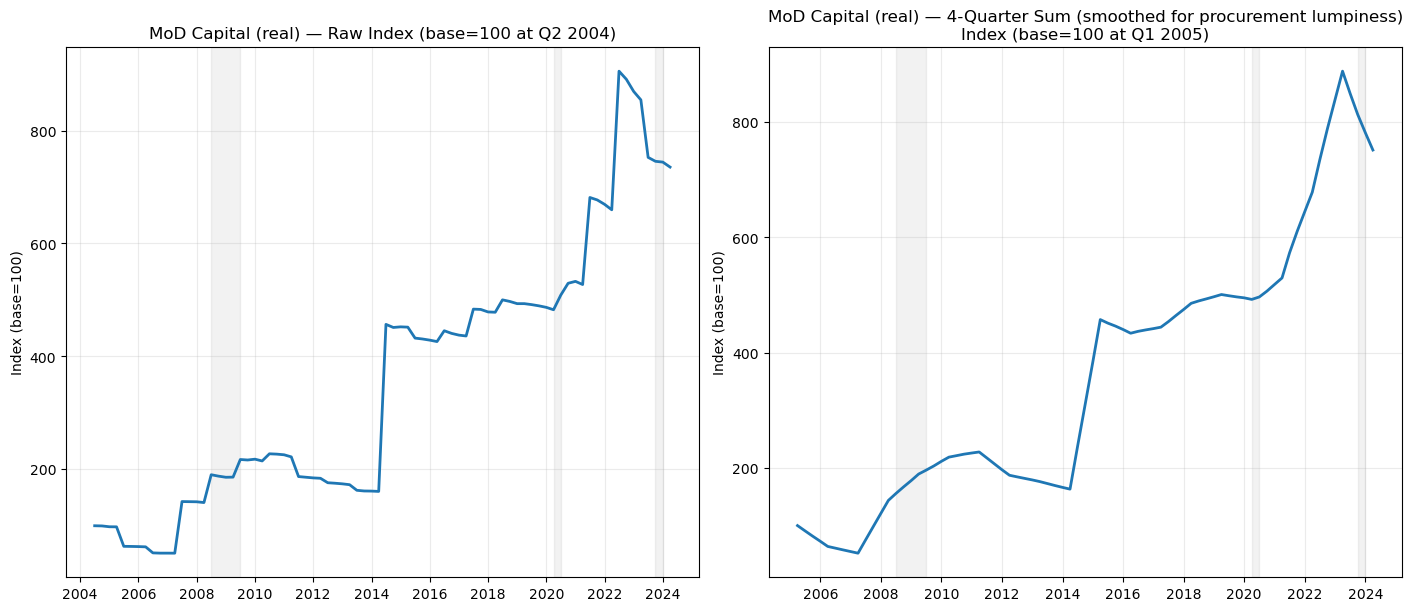

,Series,Index base quarter,Base value (original units),Index base value,Note
0,MoD Capital (real) — Raw,Q2 2004,613.74,100.000000,Raw capital rebased to first visible quarter.
1,MoD Capital (real) — 4Q Sum (Smoothed),Q1 2005,"2,430.50",100.000000,Smoothed uses first quarter with a 4-quarter sum (needs 4 quarters).


Saved outputs:
 - Figure: figures\phaseB_capital_real_index_raw_vs_smoothed.png
 - Table : figures\phaseB_capital_index_bases.csv


In [3]:
# Phase B — Capital (real): Raw vs 4Q Sum + Base Table (robust shading)
# ---------------------------------------------------------------------
from __future__ import annotations
import warnings, glob, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display

# ----------------------- Config -----------------------
SEARCH_PATTERNS = [
    "data/processed/master_panel_*.csv",
    "data/processed/master_panel.csv",
    "/mnt/data/master_panel_*.csv",
    "/mnt/data/master_panel.csv",
    # Parquet (if present)
    "data/processed/master_panel_*.parquet",
    "data/processed/master_panel.parquet",
    "/mnt/data/master_panel_*.parquet",
    "/mnt/data/master_panel.parquet",
]
FIG_DIR = Path("figures")
FIG_DPI = 160
START_Q = "2004Q2"   # keep consistent with earlier plots; set None for full span
END_Q   = None
# ------------------------------------------------------

# ------- Synonym groups (aligned to your A02 master) -------
GDP_REAL_SYNS   = ["gdp_real_mn","gdp_real_abmi","gdp_real","real_gdp_abmi","rgdp_abmi","rgdp"]
GDP_NOM_SYNS    = ["gdp_nom_mn","gdp_nominal_mn","gdp_nominal","ybha_nominal","ybha_mn","gdp_nom"]
DEFLATOR_SYNS   = ["gdp_deflator_index","gdp_deflator_ybgb","ybgb_index","deflator_index"]
MOD_CAP_NOM     = ["capital","mod_cap_nom","mod_capital_nom","mod_capital_nominal","mod_cap_nom_mn"]
MOD_CAP_REAL    = ["mod_cap_real","mod_capital_real","mod_cap_const","mod_cap_chain"]
ESCOE_SYNS      = ["escoe_recession","escoe_rec","escoe_recession_flag"]
# -----------------------------------------------------------

def _read_any(p: Path) -> pd.DataFrame:
    suff = p.suffix.lower()
    if suff == ".csv":
        return pd.read_csv(p)
    if suff in {".parquet",".pq"}:
        return pd.read_parquet(p)
    raise ValueError(f"Unsupported file type: {suff}")

def _list_master_candidates(patterns: list[str]) -> list[Path]:
    hits = []
    for pat in patterns:
        hits.extend([Path(x) for x in glob.glob(pat)])
    return [p for p in hits if p.is_file()]

def _find_best_master(patterns: list[str]) -> Path:
    cands = _list_master_candidates(patterns)
    if not cands:
        raise FileNotFoundError("No master panel found in expected locations.")
    # Prefer newest with most anchor measures present
    anchor = GDP_REAL_SYNS + GDP_NOM_SYNS + DEFLATOR_SYNS + MOD_CAP_NOM + MOD_CAP_REAL + ESCOE_SYNS
    best, best_score, best_mtime = None, -1, -1
    for p in cands:
        try:
            df = _read_any(p)
            avail = set(df["measure"].astype(str).unique()) if {"measure","period","value"}.issubset(df.columns) else set(map(str, df.columns))
            score = sum(m in avail for m in anchor)
            mtime = p.stat().st_mtime
            if score > best_score or (score == best_score and mtime > best_mtime):
                best, best_score, best_mtime = p, score, mtime
        except Exception:
            continue
    return best or max(cands, key=lambda x: x.stat().st_mtime)

# ---------- Quarter parsing ----------
_Q_PATTERNS = [
    re.compile(r"^\s*(\d{4})\s*[-_/]?\s*[Qq]\s*([1-4])\s*$"),   # 2004Q1 or 2004-Q1
    re.compile(r"^\s*[Qq]\s*([1-4])\s*[-_/]?\s*(\d{4})\s*$"),   # Q1 2004
]
def _normalize_quarter_strings(vals) -> pd.Series:
    s = pd.Series(vals).astype("string").str.strip()
    def _norm_one(x: str | None) -> str | None:
        if not x or x.lower() == "nan": return None
        for pat in _Q_PATTERNS:
            m = pat.match(x)
            if m:
                y,q = (m.group(1), m.group(2)) if pat is _Q_PATTERNS[0] else (m.group(2), m.group(1))
                return f"{y}Q{q}"
        if re.match(r"^\d{4}Q[1-4]$", x): return x
        dt = pd.to_datetime(x, errors="coerce")
        if pd.isna(dt): return None
        per = pd.Period(dt, freq="Q")
        return f"{per.year}Q{per.quarter}"
    return s.map(_norm_one)

def _ensure_quarter_end_index(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for c in ["quarter_end","Quarter_end","quarterEnd","QuarterEnd"]:
        if c in out.columns:
            dt = pd.to_datetime(out[c], errors="coerce")
            out = out.loc[~dt.isna()].drop(columns=[c])
            out.index = dt[~dt.isna()].to_period("Q").to_timestamp(how="end")
            return out.sort_index()
    for c in ["period","quarter","Quarter","date","Date"]:
        if c in out.columns:
            norm = _normalize_quarter_strings(out[c])
            good = ~norm.isna()
            per = pd.PeriodIndex(norm[good].tolist(), freq="Q")
            out = out.loc[good].drop(columns=[c])
            out.index = per.to_timestamp(how="end")
            return out.sort_index()
    if isinstance(out.index, pd.PeriodIndex):
        return out.sort_index().to_timestamp(how="end")
    if isinstance(out.index, pd.DatetimeIndex):
        out.index = out.index.to_period("Q").to_timestamp(how="end")
        return out.sort_index()
    raise ValueError("Could not locate a usable quarter column/index.")

def _to_wide(df: pd.DataFrame) -> pd.DataFrame:
    if {"measure","period","value"}.issubset(df.columns):
        wide = df.pivot(index="period", columns="measure", values="value")
        wide.columns = [str(c) for c in wide.columns]
        wide = wide.reset_index()
    else:
        wide = df.copy()
    return _ensure_quarter_end_index(wide)

# ---------- Helpers ----------
def _pick(df: pd.DataFrame, candidates: list[str]) -> str | None:
    for c in candidates:
        if c in df.columns: return c
    return None

def _growth_pct(s: pd.Series, lag: int) -> pd.Series:
    return s.pct_change(lag, fill_method=None) * 100.0

def _compute_technical_recession_flags(rgdp: pd.Series) -> pd.Series:
    qoq = _growth_pct(rgdp, 1)
    neg = qoq < 0
    blocks = (neg != neg.shift()).cumsum()
    runlen = blocks.groupby(blocks).transform("size")
    return (neg & (runlen >= 2)).rename("rec_tech")

def _recession_spans(flag: pd.Series | None) -> list[tuple[pd.Timestamp, pd.Timestamp]]:
    if flag is None:
        return []
    s = flag.copy().fillna(False).astype(bool)
    s.index = pd.to_datetime(s.index)
    starts = s & ~s.shift(1, fill_value=False)
    ends   = s & ~s.shift(-1, fill_value=False)
    return [(pd.Timestamp(st), pd.Timestamp(en) + pd.offsets.Day(1))
            for st, en in zip(starts.index[starts], ends.index[ends])]

def _quarter_label(ts: pd.Timestamp) -> str:
    p = ts.to_period("Q")
    return f"Q{p.quarter} {p.year}"

def _index_to_100(series: pd.Series, base_ts: pd.Timestamp) -> pd.Series:
    base_val = series.loc[base_ts]
    return (series / base_val) * 100.0

# --------------------------- MAIN ---------------------------
def main():
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    src = _find_best_master(SEARCH_PATTERNS)
    df  = _to_wide(_read_any(src))

    # Optional time window
    if START_Q or END_Q:
        per = df.index.to_period("Q")
        mask = pd.Series(True, index=df.index)
        if START_Q: mask &= per >= pd.Period(START_Q, freq="Q")
        if END_Q:   mask &= per <= pd.Period(END_Q,   freq="Q")
        df = df.loc[mask]

    # ---- Recession shading: prefer ESCoE, else technical if GDP available; else none ----
    spans = []
    escoe = _pick(df, ESCOE_SYNS)
    if escoe:
        rec = df[escoe].astype(int).astype(bool)
        spans = _recession_spans(rec)
    else:
        gdp_real = _pick(df, GDP_REAL_SYNS)
        if gdp_real is None:
            gdp_nom  = _pick(df, GDP_NOM_SYNS)
            deflator = _pick(df, DEFLATOR_SYNS)
            if gdp_nom and deflator:
                denom = (df[deflator] / 100.0).replace({0: np.nan})
                df["gdp_real_mn_autogen"] = df[gdp_nom] / denom
                gdp_real = "gdp_real_mn_autogen"
        if gdp_real is not None:
            rec = _compute_technical_recession_flags(df[gdp_real])
            spans = _recession_spans(rec)
        else:
            warnings.warn("Recession shading skipped: no ESCoE flag and GDP not available to compute technical recessions.", stacklevel=1)

    # ---- Build / pick real CAPITAL ----
    cap_real = _pick(df, MOD_CAP_REAL)
    if cap_real is None:
        cap_nom  = _pick(df, MOD_CAP_NOM)
        deflator = _pick(df, DEFLATOR_SYNS)
        if not (cap_nom and deflator):
            raise KeyError("Missing capital nominal or deflator; cannot construct real capital.")
        denom = (df[deflator] / 100.0).replace({0: np.nan})
        df["mod_cap_real_autogen"] = df[cap_nom] / denom
        cap_real = "mod_cap_real_autogen"

    # ---- Create indices: raw & smoothed (4Q sum) ----
    # Raw base = first visible quarter (e.g., Q2 2004)
    base_raw_ts = df.index.min()
    base_raw_lbl = _quarter_label(base_raw_ts)
    idx_cap_raw = _index_to_100(df[cap_real], base_raw_ts)

    # 4Q sum: base at the first quarter where sum exists (needs 4 quarters)
    cap4 = df[cap_real].rolling(4, min_periods=4).sum()
    base_sm_ts = cap4.first_valid_index()
    if base_sm_ts is None:
        raise ValueError("Not enough quarters to compute a 4-quarter sum for capital.")
    base_sm_lbl = _quarter_label(base_sm_ts)
    idx_cap_sm = _index_to_100(cap4, base_sm_ts)

    # ---- Plot: side-by-side raw vs smoothed ----
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), constrained_layout=True, sharey=False)

    # Left: raw
    ax = axes[0]
    ax.plot(idx_cap_raw.index, idx_cap_raw, linewidth=2)
    for st, en in spans: ax.axvspan(st, en, color="grey", alpha=0.1)
    ax.set_title(f"MoD Capital (real) — Raw Index (base=100 at {base_raw_lbl})")
    ax.set_ylabel("Index (base=100)")
    ax.set_xlabel("")
    ax.grid(True, alpha=0.25)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    # Right: smoothed (4Q sum)
    ax = axes[1]
    ax.plot(idx_cap_sm.index, idx_cap_sm, linewidth=2)
    for st, en in spans: ax.axvspan(st, en, color="grey", alpha=0.1)
    ax.set_title(f"MoD Capital (real) — 4-Quarter Sum (smoothed for procurement lumpiness)\nIndex (base=100 at {base_sm_lbl})")
    ax.set_ylabel("Index (base=100)")
    ax.set_xlabel("")
    ax.grid(True, alpha=0.25)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    out_fig = FIG_DIR / "phaseB_capital_real_index_raw_vs_smoothed.png"
    fig.savefig(out_fig, dpi=FIG_DPI)
    plt.show()

    # ---- Index base table (for the dissertation tables) ----
    base_table = pd.DataFrame({
        "Series": ["MoD Capital (real) — Raw",
                   "MoD Capital (real) — 4Q Sum (Smoothed)"],
        "Index base quarter": [base_raw_lbl, base_sm_lbl],
        "Base value (original units)": [df[cap_real].loc[base_raw_ts], cap4.loc[base_sm_ts]],
        "Index base value": [100.0, 100.0],
        "Note": ["Raw capital rebased to first visible quarter.",
                 "Smoothed uses first quarter with a 4-quarter sum (needs 4 quarters)."]
    })

    # Show in notebook
    display(base_table.style.format({"Base value (original units)": "{:,.2f}"}))

    # Save as CSV
    out_csv = FIG_DIR / "phaseB_capital_index_bases.csv"
    base_table.to_csv(out_csv, index=False)

    print("Saved outputs:")
    print(f" - Figure: {out_fig}")
    print(f" - Table : {out_csv}")

# Run
main()